## 回测引擎设置

In [1]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    df = engine.calculateDailyResult()
    return df

## 均线止损策略

In [2]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    fastPeriod = 20; slowPeriod = 40
    signalMaPeriod = 20
    stopRatio = 0.04
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod',
                 'slowPeriod',
                 'signalMaPeriod',
                 'stopRatio'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return

        signalMa = ta.EMA(am15.close, self.signalMaPeriod)

        maUp = signalMa[-1]>signalMa[-3] # 均线上涨
        maDn = signalMa[-1]<signalMa[-3] # 均线下跌
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if maUp and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if maDn and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass# 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod',
                 'slowPeriod',
                 'signalMaPeriod',
                 'stopRatio'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        
        
        # 洗价器（止盈止损）
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return

        signalMa = ta.EMA(am15.close, self.signalMaPeriod)

        maUp = signalMa[-1]>signalMa[-3] # 均线上涨
        maDn = signalMa[-1]<signalMa[-3] # 均线下跌
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if maUp and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if maDn and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
#         print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x000001C3CA041378>, <__main__.MultiFrameMaStrategy object at 0x000001C3CA068278>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000001C3CA041510>, <__main__.MultiFrameMaStrategy object at 0x000001C3CA068278>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000001C3CA041268>, <__main__.MultiFrameMaStrategy object at 0x000001C3CA068278>)
2018-11-27 17:36:45.466008	开始回测
2018-11-27 17:36:45.466008	策略初始化
2018-11-27 17:36:45.467007	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-11-27 17:36:46.100358	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-27 17:36:46.105354	载入完成，数据量：12000
2018-11-27 17:36:46.105354	策略初始化完成
2018-11-27 17:36:46.105354	策略启动完成
2018-11-27 17:36:46.105354	开始回放回测数据,回测范围:[20180901 12:00,20

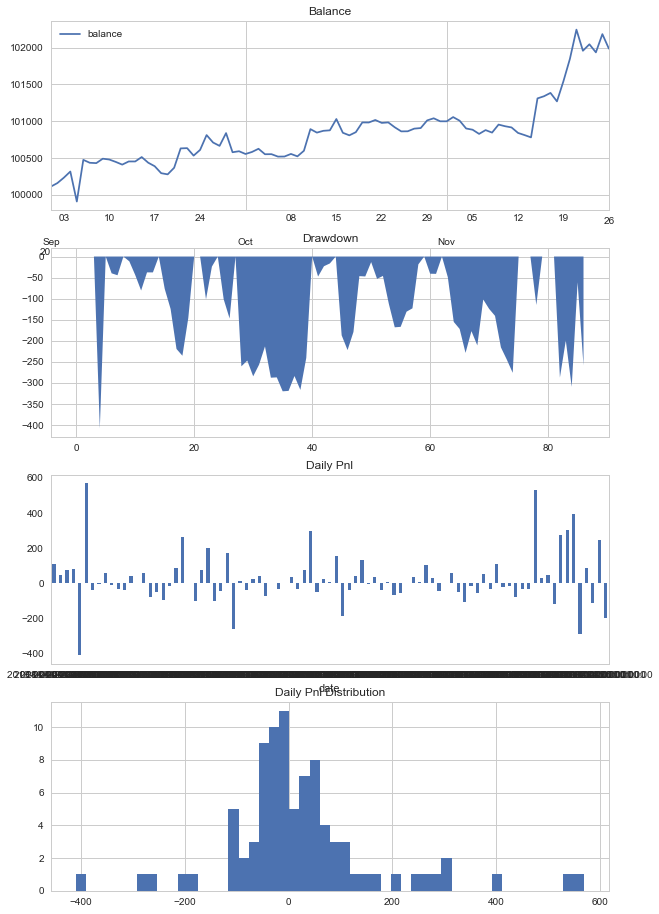

2018-11-27 17:37:05.468537	计算回测结果
2018-11-27 17:37:05.474531	------------------------------
2018-11-27 17:37:05.475529	第一笔交易：	2018-09-04 06:45:00
2018-11-27 17:37:05.475529	最后一笔交易：	2018-11-26 11:58:00
2018-11-27 17:37:05.475529	总交易次数：	70
2018-11-27 17:37:05.475529	总盈亏：	1,985.85
2018-11-27 17:37:05.475529	最大回撤: 	-964.09
2018-11-27 17:37:05.475529	平均每笔盈利：	28.37
2018-11-27 17:37:05.475529	平均每笔滑点：	0.0
2018-11-27 17:37:05.475529	平均每笔佣金：	6.13
2018-11-27 17:37:05.475529	胜率		25.71%
2018-11-27 17:37:05.475529	盈利交易平均值	317.25
2018-11-27 17:37:05.475529	亏损交易平均值	-71.63
2018-11-27 17:37:05.475529	盈亏比：	4.43


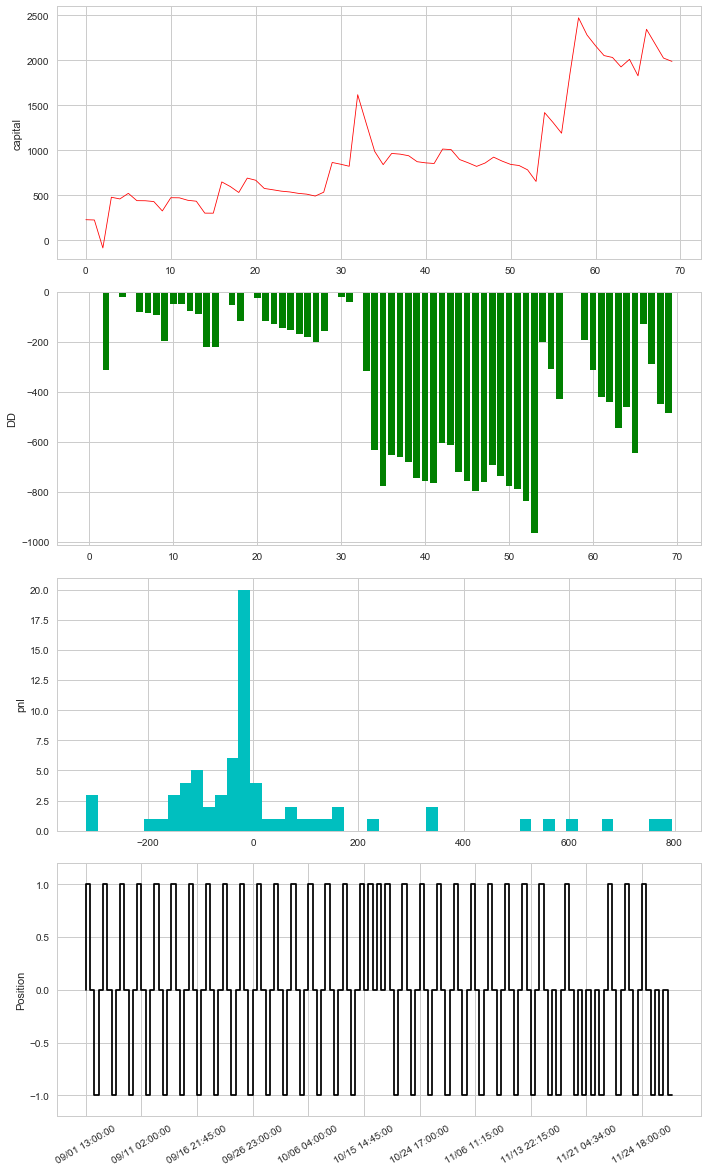

2018-11-27 17:37:06.443538	计算按日统计结果


In [3]:
MultiFrameMaDf = runBacktesting(MultiFrameMaStrategy, {'symbolList':['BTCUSDT:binance']} , '20180901 12:00', \
                            '20181126 12:00', 0.002, 5/10000)

## RSI顺势超买超卖策略

Buy: RSI<30

Sell: RSI>70

In [4]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class RsiTrendStrategy(CtaTemplate):
    className = 'RsiTrendStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    fastPeriod = 30; slowPeriod = 60
    signalMaPeriod = 20
    stopRatio = 0.03
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod', 'slowPeriod',
                 'signalMaPeriod',
                 'stopRatio'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return

        rsi = ta.RSI(am15.close, self.signalMaPeriod)

        rsiOverbought = (rsi[-1]>70) and (rsi[-2]<=70) # 超买
        rsiOversold = (rsi[-1]<30) and (rsi[-2]>=30) # 超卖
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if rsiOversold and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if rsiOverbought and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
#                 self.cancelAll() # 撤销挂单
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
#             print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function RsiTrendStrategy.on60MinBar at 0x000001C3D8950D90>, <__main__.RsiTrendStrategy object at 0x000001C3D8972668>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function RsiTrendStrategy.on15MinBar at 0x000001C3D8841D90>, <__main__.RsiTrendStrategy object at 0x000001C3D8972668>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function RsiTrendStrategy.onBar at 0x000001C3D8950598>, <__main__.RsiTrendStrategy object at 0x000001C3D8972668>)
2018-11-27 17:37:06.686291	开始回测
2018-11-27 17:37:06.686291	策略初始化
2018-11-27 17:37:06.687290	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-11-27 17:37:07.184780	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-27 17:37:07.190774	载入完成，数据量：12000
2018-11-27 17:37:07.190774	策略初始化完成
2018-11-27 17:37:07.190774	策略启动完成
2018-11-27 17:37:07.190774	开始回放回测数据,回测范围:[20180901 12:00,20181126 12:00)
2018-11-27

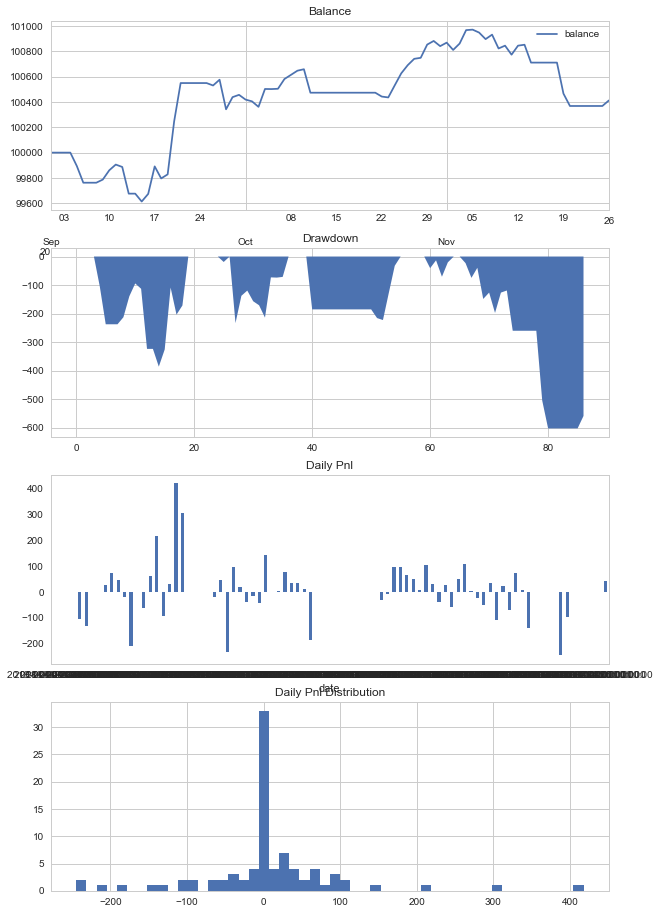

2018-11-27 17:37:26.076690	计算回测结果
2018-11-27 17:37:26.078689	------------------------------
2018-11-27 17:37:26.078689	第一笔交易：	2018-09-06 00:51:00
2018-11-27 17:37:26.078689	最后一笔交易：	2018-11-26 11:58:00
2018-11-27 17:37:26.078689	总交易次数：	19
2018-11-27 17:37:26.078689	总盈亏：	409.58
2018-11-27 17:37:26.078689	最大回撤: 	-597.16
2018-11-27 17:37:26.078689	平均每笔盈利：	21.56
2018-11-27 17:37:26.078689	平均每笔滑点：	0.0
2018-11-27 17:37:26.078689	平均每笔佣金：	6.29
2018-11-27 17:37:26.078689	胜率		63.16%
2018-11-27 17:37:26.078689	盈利交易平均值	138.08
2018-11-27 17:37:26.078689	亏损交易平均值	-178.19
2018-11-27 17:37:26.078689	盈亏比：	0.77


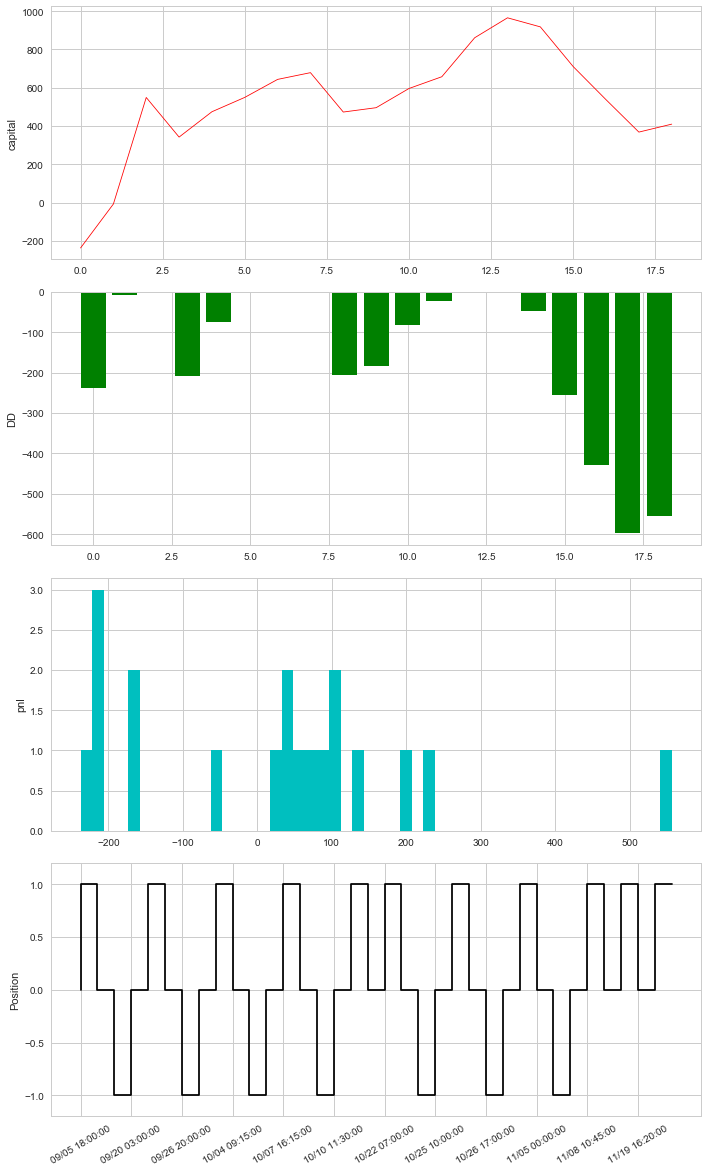

2018-11-27 17:37:26.712041	计算按日统计结果


In [5]:
rsiTrendDf = runBacktesting(RsiTrendStrategy, {'symbolList':['BTCUSDT:binance']} , '20180901 12:00', \
                            '20181126 12:00', 0.002, 5/10000)

## Strategy_Portfolio

In [6]:
MultiFrameMaDf.tail()

,netPnl,slippage,commission,turnover,tradeCount,tradingPnl,positionPnl,totalPnl
date,,,,,,,,
2018-11-22,-287.53373,0.012,13.96173,27923.46,6,-344.00,70.44,-273.56
2018-11-23,87.90607,0.004,4.52993,9059.86,2,249.88,-157.44,92.44
2018-11-24,-109.95526,0.004,4.44126,8882.52,2,-138.48,32.97,-105.51
2018-11-25,248.45175,0.012,11.93625,23872.50,6,752.42,-492.02,260.40
2018-11-26,-197.69739,0.004,4.06339,8126.78,2,45.24,-238.87,-193.63


In [7]:
rsiTrendDf.tail()

,netPnl,slippage,commission,turnover,tradeCount,tradingPnl,positionPnl,totalPnl
date,,,,,,,,
2018-11-22,0.0000,0.000,0.0000,0.0,0,0.00,0.0,0.00
2018-11-23,0.0000,0.000,0.0000,0.0,0,0.00,0.0,0.00
2018-11-24,0.0000,0.000,0.0000,0.0,0,0.00,0.0,0.00
2018-11-25,0.0000,0.000,0.0000,0.0,0,0.00,0.0,0.00
2018-11-26,43.6457,0.002,2.0823,4164.6,1,45.73,0.0,45.73


In [8]:
PortfolioDf = MultiFrameMaDf+rsiTrendDf

In [9]:
PortfolioDf = PortfolioDf.dropna()

# 创建回测引擎，并设置组合回测初始资金后，显示结果
engine = BacktestingEngine()
engine.setCapital(1000000)
dfp, result = engine.calculateDailyStatistics(PortfolioDf)

In [10]:
result

{'annualizedReturn': 0.6619457544827818,
 'dailyCommission': 6.262007356321838,
 'dailyNetPnl': 27.581073103448254,
 'dailyReturn': 0.0026295448011353366,
 'dailySlippage': 0.004045977011494256,
 'dailyTradeCount': 2.0229885057471266,
 'dailyTurnover': 12524.014712643675,
 'endBalance': 1002399.55336,
 'endDate': Timestamp('2018-11-26 00:00:00'),
 'lossDays': 30,
 'maxDdPercent': -0.05138439214392886,
 'maxDrawdown': -514.0053199999966,
 'profitDays': 46,
 'returnStd': 0.015721744941956703,
 'sharpeRatio': 2.5911076055495266,
 'startDate': Timestamp('2018-09-01 00:00:00'),
 'totalCommission': 544.79464,
 'totalDays': 87,
 'totalNetPnl': 2399.553359999998,
 'totalReturn': 0.2399553360000084,
 'totalSlippage': 0.35200000000000026,
 'totalTradeCount': 176,
 'totalTurnover': 1089589.2799999998}

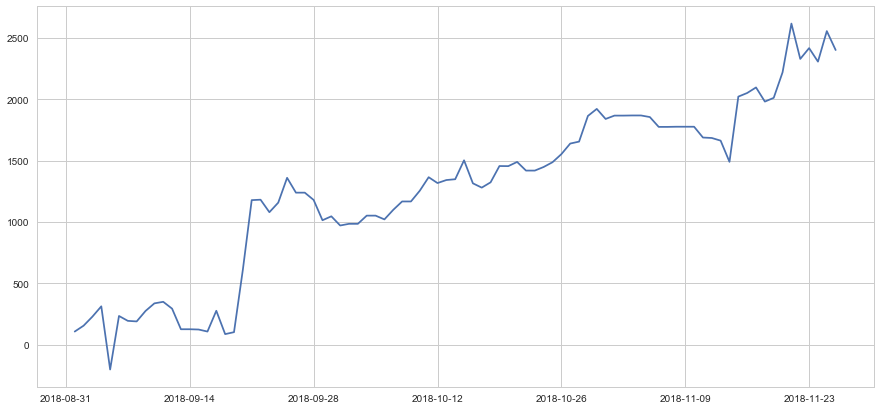

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(PortfolioDf['netPnl'].cumsum())
plt.show()